In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x',
    'y',
    'z'
]
LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]
SEGMENT_TIME_SIZE = 180
TIME_STEP = 100
RANDOM_SEED = 13

# Load the WISDM dataset
data = pd.read_csv('/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt', names=COLUMN_NAMES)
data['z'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()



In [2]:
data.head()

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
df = data.drop(['user', 'timestamp'], axis = 1).copy()
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

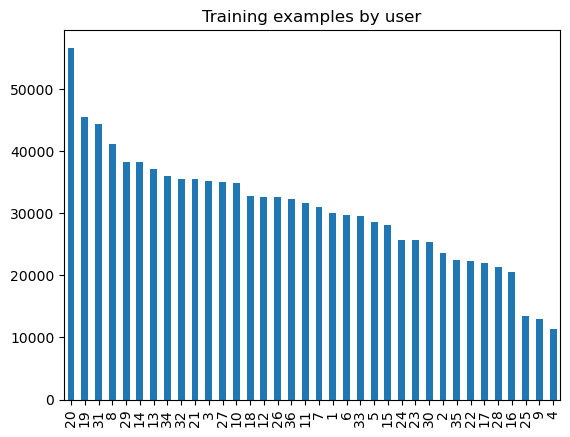

In [4]:
data['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [5]:
def plot_activity(activity, data):
    data1 = data[data['activity'] == activity][['x', 'y', 'z']][:200]
    axis = data1.plot(subplots=True, figsize=(16, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

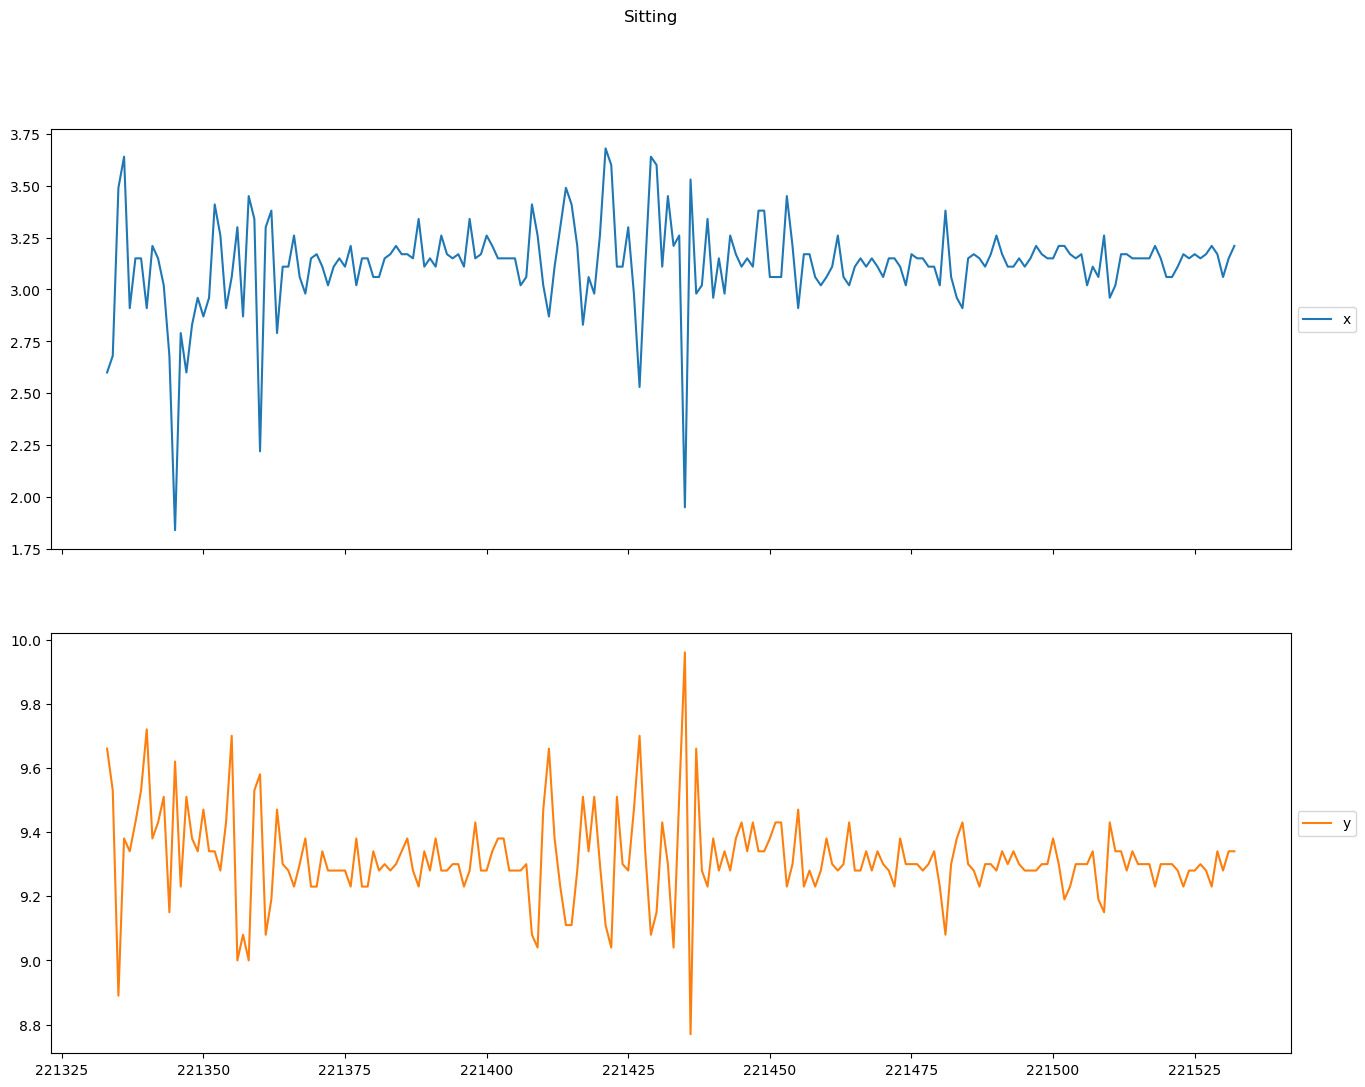

In [6]:
plot_activity("Sitting", data)

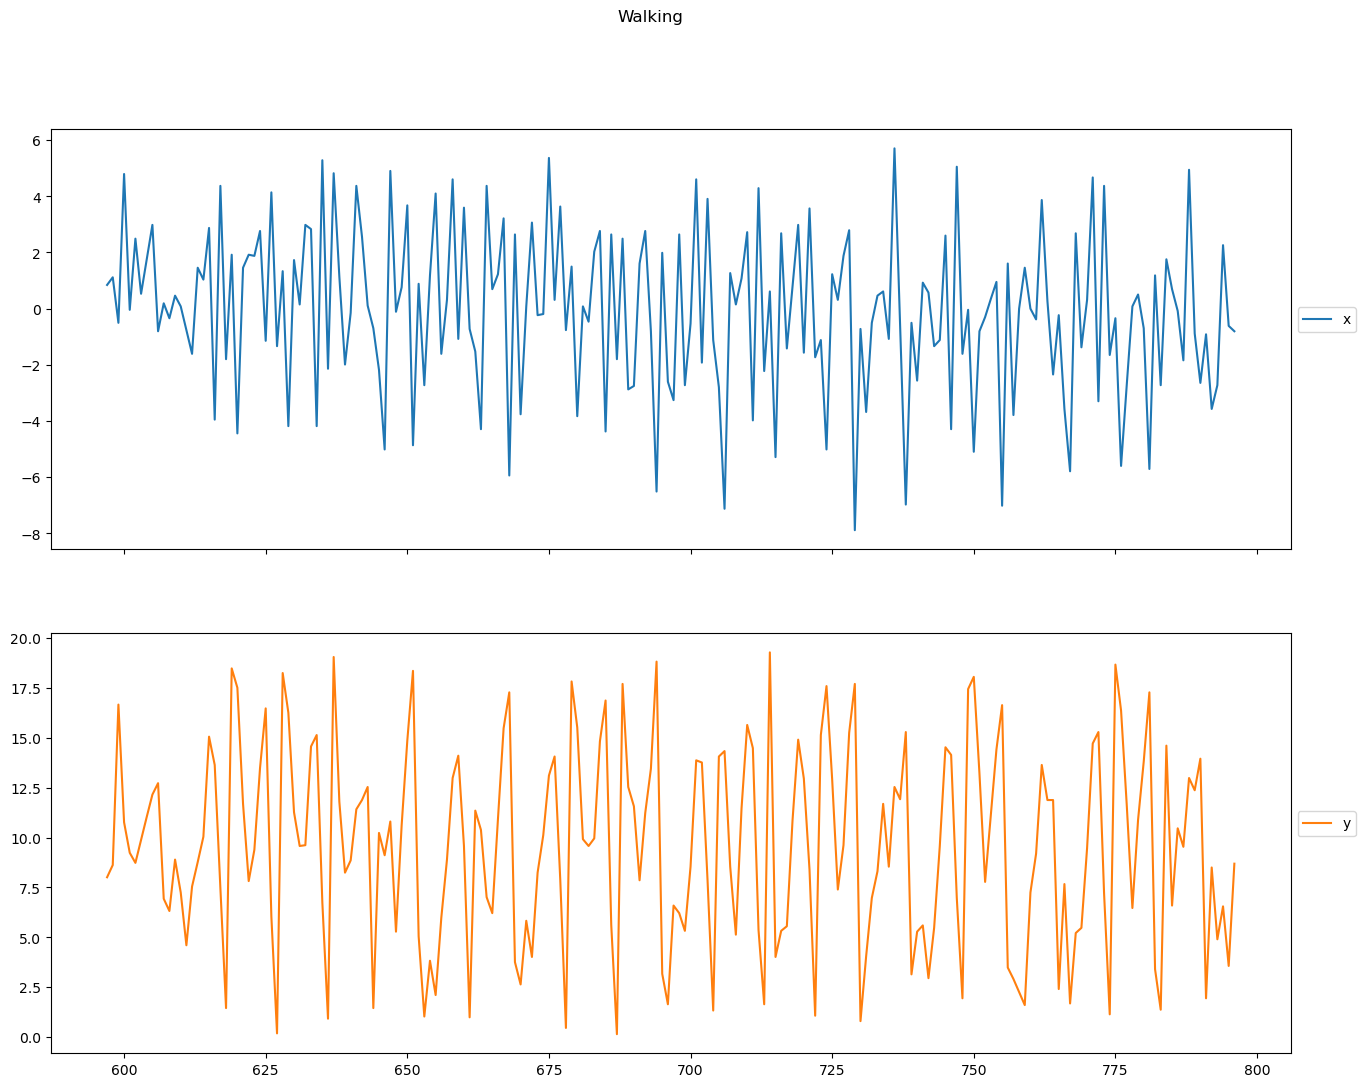

In [7]:
plot_activity("Walking", data)

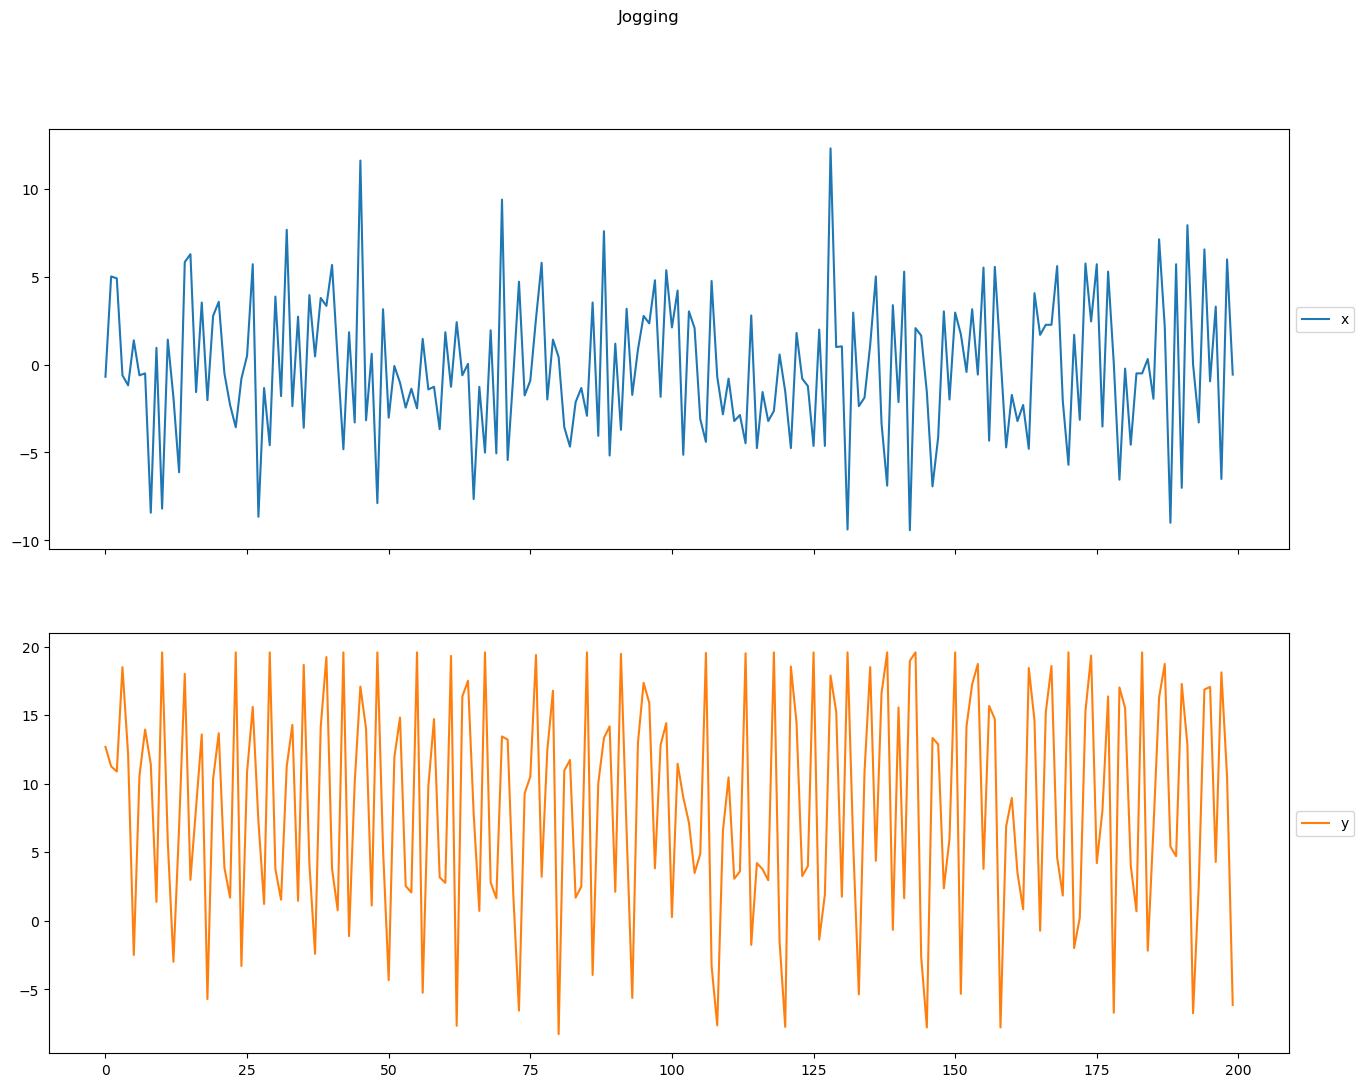

In [8]:
plot_activity("Jogging", data)

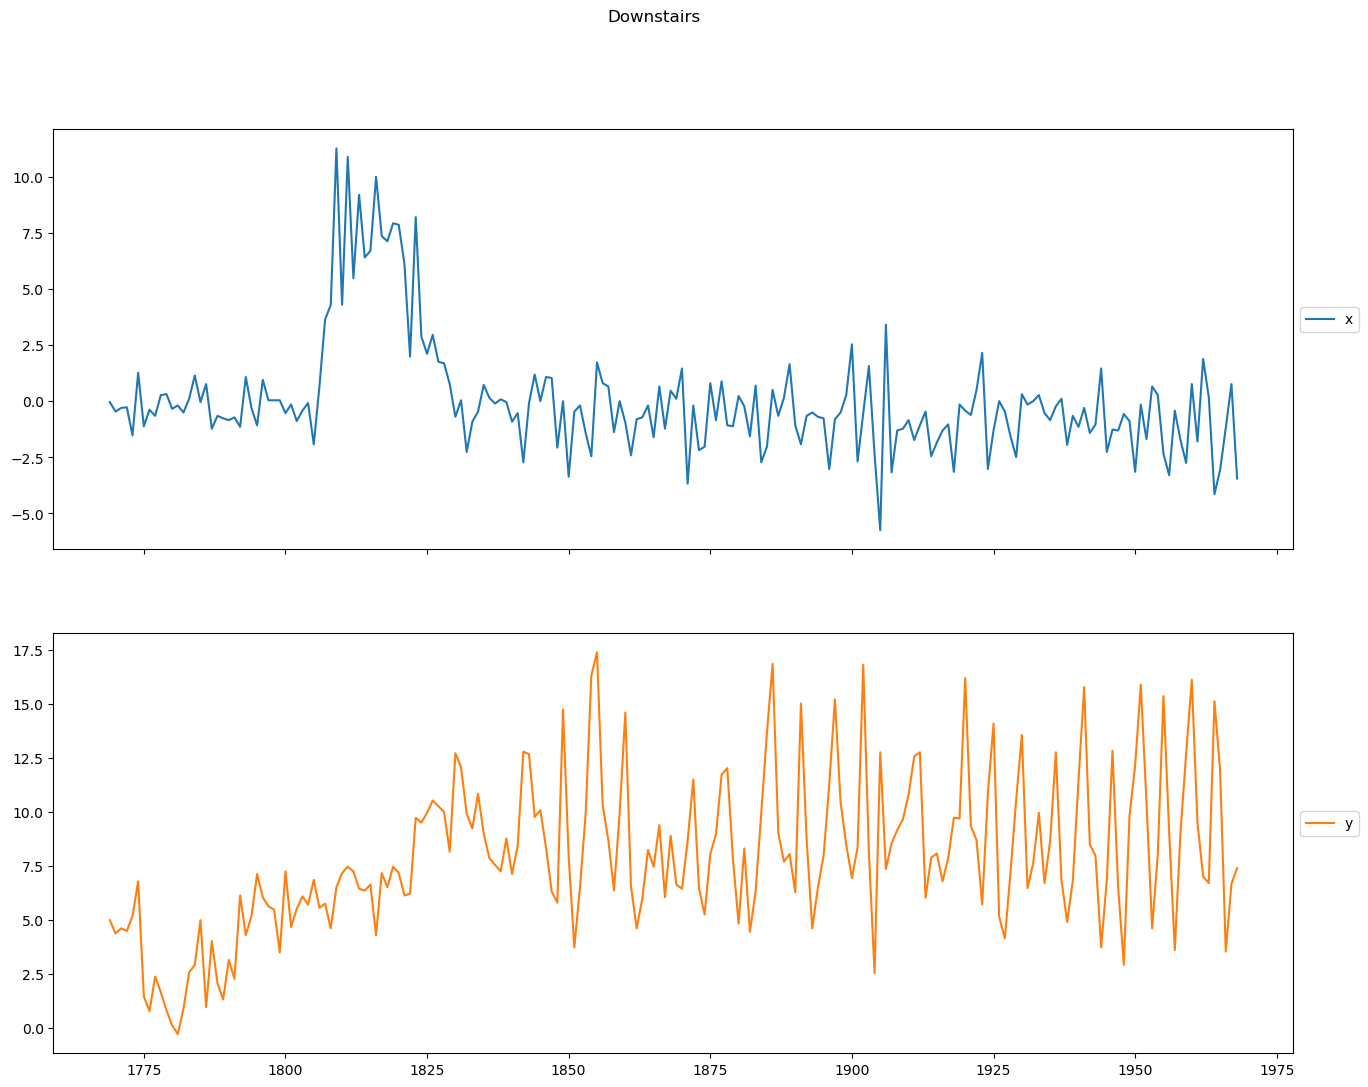

In [9]:
plot_activity("Downstairs", data)

In [10]:
data_convoluted = []
labels = []

for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x'].values[i: i + SEGMENT_TIME_SIZE]
    y = data['y'].values[i: i + SEGMENT_TIME_SIZE]
    z = data['z'].values[i: i + SEGMENT_TIME_SIZE]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_convoluted, labels, test_size=0.3, random_state=RANDOM_SEED)

# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEGMENT_TIME_SIZE, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=17, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
model.save("model.h5")

Convoluted data shape:  (10981, 180, 3)
Labels shape: (10981, 6)
121/121 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.6821
Epoch 1: val_accuracy improved from -inf to 0.78240, saving model to model.h5
52/52 [==============================] - 0s 5ms/step - loss: 0.6065 - accuracy: 0.7824
Test loss: 0.6065467000007629
Test accuracy: 0.7823975682258606


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(model.summary())

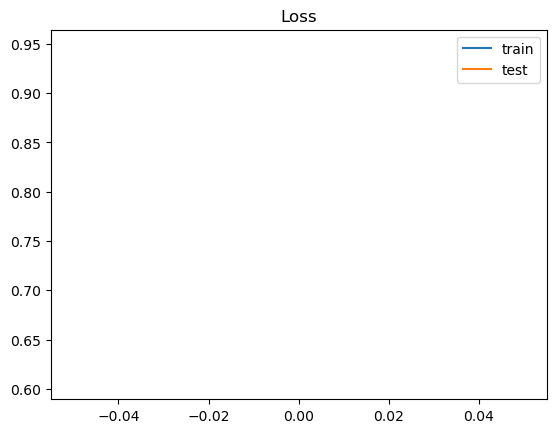

In [11]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

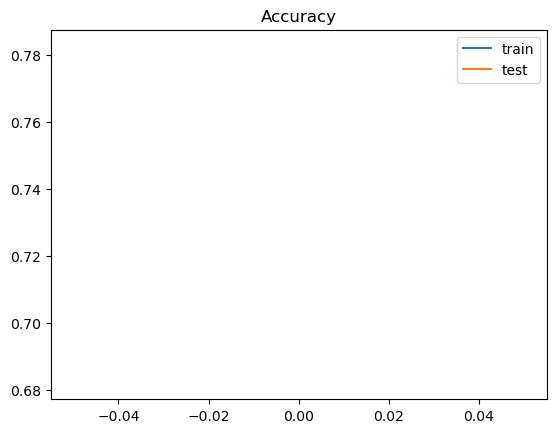

In [12]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [13]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_pred_labels, target_names=LABELS)

print("Classification Report:")
print(class_report)


103/103 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.50      0.02      0.03       312
     Jogging       0.91      0.98      0.94      1020
     Sitting       0.98      0.86      0.92       208
    Standing       0.72      0.92      0.81       132
    Upstairs       0.43      0.24      0.30       380
     Walking       0.73      0.95      0.83      1243

    accuracy                           0.78      3295
   macro avg       0.71      0.66      0.64      3295
weighted avg       0.74      0.78      0.73      3295



103/103 [==============================] - 0s 3ms/step


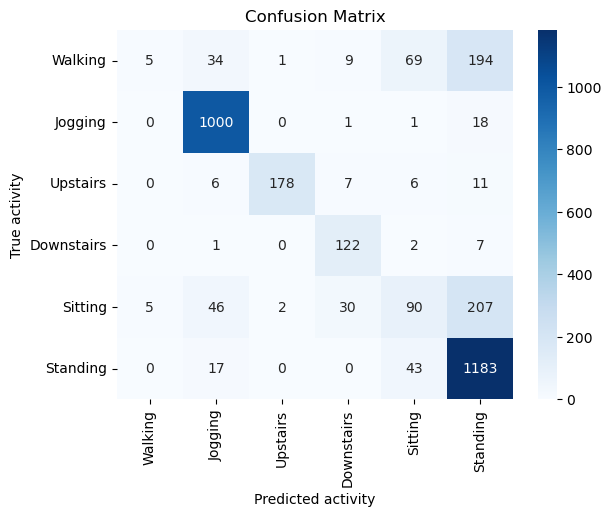

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], yticklabels=['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'])

# Add axis labels and a title
plt.xlabel('Predicted activity')
plt.ylabel('True activity')
plt.title('Confusion Matrix')

# Show the plot
plt.show()